<a href="https://colab.research.google.com/github/victorbahlangene/NLP-Disaster-Tweets-kaggle-comp/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Natural Language Processing Competition - Part 1

## Natural Language Processing with Disaster Tweets Classification

## Introduction: Business Problem

## Data

## Methodology

1. Notebook setup
2. Data
3. Tokenization
4. Metrics
5. Training
6. Predictions
7. Saving the model to huggingface

## Analysis

### Notebook Setup

In [1]:
# to use kaggle api #
!pip install -q kaggle

# kaggle API creds #
creds = '{"username":"victorbahlangene","key":"2cd1abe2f1c35ea3060e6a2f18a055ea"}'

# Then execute this cell (this only needs to be run once) #
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

# fastkaggle import #
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -q fastkaggle

from fastkaggle import *

# competion name #
comp = 'nlp-getting-started'

# path to where data will be downloaded #
path = setup_comp(comp, install='fastai')


In [2]:
path

Path('nlp-getting-started')

In [3]:
path.ls()

(#3) [Path('nlp-getting-started/test.csv'),Path('nlp-getting-started/train.csv'),Path('nlp-getting-started/sample_submission.csv')]

### Data

In [4]:
import pandas as pd

**Train data**

In [5]:
df_trn = pd.read_csv(path/"train.csv", index_col=0)
df_trn

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


keyword col

In [6]:
df_trn["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

location col

In [7]:
df_trn["location"].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

distribution of targets

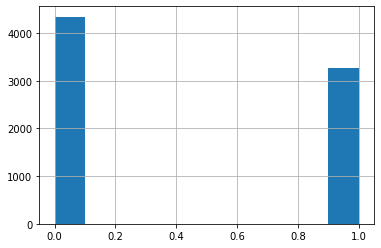

In [8]:
df_trn["target"].hist()

Some what uneven distribution of the target 

In [9]:
df_trn["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

better target(label) distribution plot

In [10]:
df_trn["target"]

id
1        1
4        1
5        1
6        1
7        1
        ..
10869    1
10870    1
10871    1
10872    1
10873    1
Name: target, Length: 7613, dtype: int64

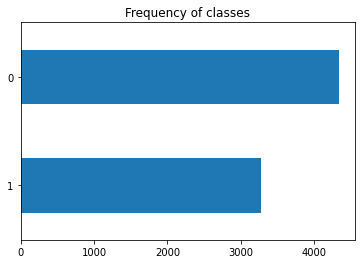

In [11]:
import matplotlib.pyplot as plt

df_trn["target"].value_counts(ascending=True).plot(kind="barh")
plt.title("Frequency of classes")
plt.show()

In [10]:
3271/(4342+3271)

0.4296597924602653

42.97% of target data = 1

**Change dtype of 'target' col from int to float**

In [11]:
# df_trn = df_trn.astype({"target": float})

In [12]:
# df_trn.dtypes

**Test data**

In [13]:
df_tst = pd.read_csv(path/"test.csv")
df_tst

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


**Submission file**

In [14]:
ss = pd.read_csv(path/"sample_submission.csv")
ss

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


### Dataset

In [15]:
# installing hugging face transformers #
!pip install -q transformers

In [16]:
# installing hugging face datasets #
!pip install -q datasets

In [17]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from datasets import Dataset, DatasetDict, load_dataset

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Convert Pandas dataframes to hugging face datasets

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# dependant variable #
target = df_trn.target

In [20]:
df_trn.drop("target", axis=1, inplace=True)

In [21]:
df_trn

,keyword,location,text
id,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...


split data into training and validation sets

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(df_trn, target, 
                                                        test_size=0.15, 
                                                        random_state=42, 
                                                        stratify=target)

In [23]:
X_train

,keyword,location,text
id,,,
4875,explode,"Yamaku Academy, Class 3-4",KS except every character is Shizune.\nThe wor...
4511,emergency,Phoenix,God forbid anyone in my family knows how to an...
4611,emergency%20services,Auckland,Emergency services unsure how to cope with los...
1421,body%20bag,NaN,Nuu that FAM?? fwt I'm Leave You In a Body bag??
5528,flattened,somewhere too cold for me,@GrabakaHitman @Izi_Garcia when he flattened m...
...,...,...,...
3118,debris,NaN,#?? #???? #??? #??? MH370: Aircraft debris fou...
579,arson,"Eldoret, kenya",#Kisii Police in Kisii hunt for students over ...
447,armageddon,"California, United States",#PBBan (Temporary:300) Russaky89 @'aRmageddon ...


In [24]:
y_train

id
4875     0
4511     0
4611     0
1421     0
5528     1
        ..
3118     1
579      1
447      0
2379     0
10819    0
Name: target, Length: 6471, dtype: int64

In [25]:
X_train["label"] = y_train
X_valid["label"] = y_valid

In [26]:
X_train

,keyword,location,text,label
id,,,,
4875,explode,"Yamaku Academy, Class 3-4",KS except every character is Shizune.\nThe wor...,0
4511,emergency,Phoenix,God forbid anyone in my family knows how to an...,0
4611,emergency%20services,Auckland,Emergency services unsure how to cope with los...,0
1421,body%20bag,NaN,Nuu that FAM?? fwt I'm Leave You In a Body bag??,0
5528,flattened,somewhere too cold for me,@GrabakaHitman @Izi_Garcia when he flattened m...,1
...,...,...,...,...
3118,debris,NaN,#?? #???? #??? #??? MH370: Aircraft debris fou...,1
579,arson,"Eldoret, kenya",#Kisii Police in Kisii hunt for students over ...,1
447,armageddon,"California, United States",#PBBan (Temporary:300) Russaky89 @'aRmageddon ...,0


check train data label distribution

In [27]:
X_train.label.value_counts()

0    3691
1    2780
Name: label, dtype: int64

In [28]:
2617/(2617+3473)

0.4297208538587849

The reason for train_test_split attribute stratify is to insure the distribution of the label in the random split is the same in the intial data.

In [29]:
X_valid

,keyword,location,text,label
id,,,,
1702,bridge%20collapse,UK,Australia's Ashes disaster - how the collapse ...,1
10748,wreckage,Africa,Malaysia PM confirms wreckage belongs to MH370...,1
1869,burned,NaN,Just burned the shit outta myself on my dirt b...,0
9374,survived,NaN,By the grace of GOD I survived the 2am shift a...,0
3876,detonation,Bangkok Thailand,A new favorite: Trivium - Detonation by @rrusa...,0
...,...,...,...,...
2515,collision,"Arvada, CO",Motorcyclist bicyclist injured in Denver colli...,1
2227,chemical%20emergency,NaN,Google Alert: Emergency units simulate a chemi...,0
2797,curfew,IM LOST,Da Judge Gave Dis Girl 5pm Curfew ??????,0


In [30]:
X_valid.label.value_counts()

0    651
1    491
Name: label, dtype: int64

In [31]:
654/(654+869)

0.4294156270518713

In [32]:
train_ds = Dataset.from_pandas(X_train)
valid_ds = Dataset.from_pandas(X_valid)

In [33]:
train_ds, valid_ds

(Dataset({
     features: ['keyword', 'location', 'text', 'label', 'id'],
     num_rows: 6471
 }), Dataset({
     features: ['keyword', 'location', 'text', 'label', 'id'],
     num_rows: 1142
 }))

In [34]:
tweets = DatasetDict()
tweets

DatasetDict({
    
})

In [35]:
type(tweets)

datasets.dataset_dict.DatasetDict

add train_ds and valid_ds to tweets DatasetDict

In [36]:
tweets["train"] = train_ds
tweets["valid"] = valid_ds

In [37]:
tweets

DatasetDict({
    train: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id'],
        num_rows: 1142
    })
})

Load test data into a dataset

In [38]:
tst_path = path/"test.csv"
tst_path

Path('nlp-getting-started/test.csv')

In [72]:
tweets_test = load_dataset("csv", data_files={"test": str(tst_path)})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b992f3df67d9f515/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
tweets_test

DatasetDict({
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})

### Tokenization

In [41]:
# add sequence classification model #
model_name = "microsoft/deberta-v3-small" 
# model_name = "distilbert-base-uncased" 

In [42]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
tokz = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


test tokenizer

In [44]:
tokz("Not one will see nor bird nor tree if mankind perished utterly")

{'input_ids': [1, 951, 311, 296, 398, 2498, 4523, 2498, 1953, 337, 12774, 39838, 11194, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [45]:
tokz("Not one will see nor bird nor tree if mankind perished utterly", padding=True, truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [1, 951, 311, 296, 398, 2498, 4523, 2498, 1953, 337, 12774, 39838, 11194, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**Tokenize Function**

In [44]:
def tokenize(batch):
  return tokz(batch["text"], padding=True, truncation=True)

test tokenize() function

In [47]:
tweets['train'][0]

{'keyword': 'snowstorm',
 'location': 'South, USA',
 'text': 'Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #ibooklove #bookboost',
 'label': 1,
 'id': 8902}

In [48]:
tokenize(tweets['train'][0])

{'input_ids': [1, 71041, 707, 1651, 658, 46337, 18878, 267, 40495, 4255, 44699, 953, 558, 795, 10699, 1871, 294, 320, 320, 297, 260, 1902, 320, 19983, 1301, 1207, 1193, 297, 297, 268, 691, 1088, 953, 667, 5749, 10439, 953, 5749, 43563, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**Tokenize Datasets**

In [47]:
tweets_tokz = tweets.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [74]:
eval_tweets_test_tokz = tweets_test.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [49]:
# train tokenized dataset #
tweets_tokz

DatasetDict({
    train: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

In [75]:
# evaluation tekenized dataset #
eval_tweets_test_tokz

DatasetDict({
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3263
    })
})

### Metrics

using huggingface evaluate

In [53]:
# !pip install -q evaluate

In [54]:
# import evaluate

In [55]:
# def compute_metrics(eval_pred):
#   f1_metric = evaluate.load("f1")
#   accuracy = evaluate.load("accuracy")
  
#   predictions = eval_pred.predictions.argmax(-1)
#   labels = eval_pred.label_ids
#   results_f1_metric = f1_metric.compute(predictions=predictions, references=labels)
#   results_accuracy = accuracy.compute(predictions=predictions, references=labels)
#   return results_f1_metric, results_accuracy

Using sklearn

In [51]:
from sklearn.metrics import accuracy_score, f1_score

In [52]:
def compute_metrics2(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### huggingface loggin

This is to save the model on the hugging face hub. 

see link: how to setup hugging face hub

In [53]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


### Training

Training model

In [54]:
# for training in transformers #
from transformers import TrainingArguments, Trainer

In [55]:
# view model name #
model_name

'microsoft/deberta-v3-small'

In [56]:
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

batch size and training epochs

In [57]:
bs = 32 ## can be 64 or 132, depends on the memory of your GPU
epochs = 2
full_model_name = f"{model_name}-finetuned-Disaster-Tweets-Part1"

In [63]:
full_model_name

'microsoft/deberta-v3-small-finetuned-Disaster-Tweets-Part1'

In [59]:
# learning rate #
lr = 2e-5

**Training Arguments**

In [60]:
args = TrainingArguments(output_dir=full_model_name, 
                         learning_rate=lr, 
                         warmup_ratio=0.1, 
                         lr_scheduler_type='cosine', 
                         fp16=True,
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=bs,
                         per_device_eval_batch_size=bs*2,
                         num_train_epochs=epochs,
                         weight_decay=0.01,
                         report_to='none')

**Create Trainer**

In [76]:
eval_tweets_test_tokz

DatasetDict({
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3263
    })
})

In [77]:
tweets_tokz

DatasetDict({
    train: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

In [61]:
trainer = Trainer(model, args, train_dataset=tweets_tokz['train'], eval_dataset=tweets_tokz['valid'],
                  tokenizer=tokz, compute_metrics=compute_metrics2)

Using cuda_amp half precision backend


In [62]:
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, id. If text, keyword, location, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6471
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 406
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster tha

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.382815,0.841506,0.841445
2,No log,0.401400,0.856392,0.855747


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, id. If text, keyword, location, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1142
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale, dtype=query_layer.dtype
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

### Predictions

**Preds of validation data**

In [63]:
preds_valid = trainer.predict(tweets_tokz['valid'])

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, id. If text, keyword, location, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1142
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale, dtype=query_layer.dtype
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [64]:
preds_valid.predictions

array([[-2.412 ,  2.408 ],
       [-2.494 ,  2.533 ],
       [ 1.075 , -1.277 ],
       ...,
       [ 0.839 , -1.05  ],
       [ 1.273 , -1.443 ],
       [-0.618 ,  0.4905]], dtype=float16)

In [65]:
preds_valid.predictions.shape

(1142, 2)

In [66]:
preds_valid.predictions.argmax(-1)

array([1, 1, 0, ..., 0, 0, 1])

Correct labels of the validation data set

In [68]:
preds_valid.label_ids

array([1, 1, 0, ..., 0, 0, 1])

summary of metrics on validaion data

In [69]:
preds_valid.metrics

{'test_loss': 0.4013996720314026,
 'test_accuracy': 0.8563922942206655,
 'test_f1': 0.8557467716579698,
 'test_runtime': 1.2951,
 'test_samples_per_second': 881.773,
 'test_steps_per_second': 13.898}

Preds of test data

In [78]:
eval_tweets_test_tokz

DatasetDict({
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3263
    })
})

In [79]:
eval_tweets_test_tokz["test"]

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [80]:
preds_test_data = trainer.predict(eval_tweets_test_tokz["test"])

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, id. If text, keyword, location, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale, dtype=query_layer.dtype
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [81]:
preds_test_data.predictions

array([[-2.42 ,  2.285],
       [-1.734,  1.676],
       [-2.55 ,  2.467],
       ...,
       [-2.5  ,  2.535],
       [-2.445,  2.404],
       [-1.989,  1.923]], dtype=float16)

In [82]:
preds_test_data.predictions.shape

(3263, 2)

In [83]:
preds_test_data.predictions.argmax(-1)

array([1, 1, 1, ..., 1, 1, 1])

In [85]:
preds_test_data.metrics

{'test_runtime': 3.6976,
 'test_samples_per_second': 882.465,
 'test_steps_per_second': 13.793}

### Confussion matrix

this is a method of displaying how well our model performed against the actual labels of the data.

**Plot confusion matrix**

needs:
- y_preds
- y_true
- labels

y_preds

In [ ]:
# import numpy as np

# y_preds = np.argmax(pred_output.predictions, axis=1)
# y_preds

In [90]:
y_preds = preds_valid.predictions.argmax(-1)

y_true

In [91]:
tweets_tokz

DatasetDict({
    train: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    valid: Dataset({
        features: ['keyword', 'location', 'text', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

In [92]:
y_true = tweets_tokz["valid"]["label"]
print(y_true)

[1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 

labels

In [114]:
labels = ["1","0"]

In [115]:
labels

['1', '0']

confussion matrix function

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


plot Confussion matrix

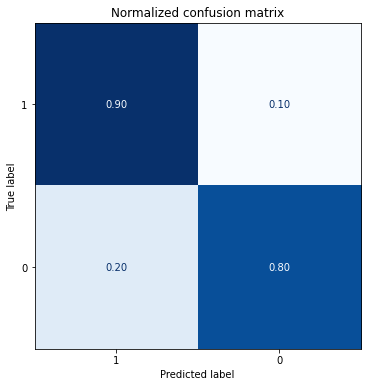

In [117]:
plot_confusion_matrix(y_preds, y_true, labels)

### Saving and sharing the model

In [86]:
trainer.push_to_hub(commit_message="Training complete model 1")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:708: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  FutureWarning,
Cloning https://huggingface.co/victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1 into local empty directory.
Saving model checkpoint to microsoft/deberta-v3-small-finetuned-Disaster-Tweets-Part1
Configuration saved in microsoft/deberta-v3-small-finetuned-Disaster-Tweets-Part1/config.json
Model weights saved in microsoft/deberta-v3-small-finetuned-Disaster-Tweets-Part1/pytorch_model.bin
tokenizer config file saved in microsoft/deberta-v3-small-finetuned-Disaster-Tweets-Part1/tokenizer_config.json
Special tokens file saved in microsoft/deberta-v3-small-finetuned-Disaster-Tweets-Part1/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 3.34k/541M [00:00<?, ?B/s]

Upload file spm.model:   0%|          | 3.34k/2.35M [00:00<?, ?B/s]

Upload file training_args.bin:  99%|#########9| 3.34k/3.36k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1
   3e4ee27..85913cb  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1
   3e4ee27..85913cb  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.8563922942206655}, {'name': 'F1', 'type': 'f1', 'value': 0.8557467716579698}]}
To https://huggingface.co/victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1
   85913cb..8a3141d  main -> main

   85913cb..8a3141d  main -> main



'https://huggingface.co/victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1/commit/85913cb370103a49d15230bea9611043cbc5522b'

### use the model via pipeline

now anyone who has access to hugging face can use the model

In [119]:
from transformers import pipeline

In [120]:
model_id = "victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/880 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--victorbahlangene--deberta-v3-small-finetuned-Disaster-Tweets-Part1/snapshots/8a3141db2ec862b12468fc2effc84cc94edb566c/config.json
Model config DebertaV2Config {
  "_name_or_path": "victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,


Downloading:   0%|          | 0.00/568M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--victorbahlangene--deberta-v3-small-finetuned-Disaster-Tweets-Part1/snapshots/8a3141db2ec862b12468fc2effc84cc94edb566c/pytorch_model.bin
All model checkpoint weights were used when initializing DebertaV2ForSequenceClassification.

All the weights of DebertaV2ForSequenceClassification were initialized from the model checkpoint at victorbahlangene/deberta-v3-small-finetuned-Disaster-Tweets-Part1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DebertaV2ForSequenceClassification for predictions without further training.


Downloading:   0%|          | 0.00/400 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

loading file spm.model from cache at /root/.cache/huggingface/hub/models--victorbahlangene--deberta-v3-small-finetuned-Disaster-Tweets-Part1/snapshots/8a3141db2ec862b12468fc2effc84cc94edb566c/spm.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--victorbahlangene--deberta-v3-small-finetuned-Disaster-Tweets-Part1/snapshots/8a3141db2ec862b12468fc2effc84cc94edb566c/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--victorbahlangene--deberta-v3-small-finetuned-Disaster-Tweets-Part1/snapshots/8a3141db2ec862b12468fc2effc84cc94edb566c/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--victorbahlangene--deberta-v3-small-finetuned-Disaster-Tweets-Part1/snapshots/8a3141db2ec862b12468fc2effc84cc94edb566c/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--victorbahlangene--deberta-v3-small-finetuned-Disaste

test model

In [123]:
custom_tweet = "Oh my gosh LA is in complete chaos. cant find an open ice cream shop"

preds = classifier(custom_tweet, top_k=1)

 predict 1 if the tweet is describing a real disaster, and 0 otherwise. 

In [124]:
preds

[{'label': 'LABEL_0', 'score': 0.8816471099853516}]

## Submit to kaggle

In [126]:
tweets_test

DatasetDict({
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})

In [128]:
print(tweets_test["test"]["id"])

[0, 2, 3, 9, 11, 12, 21, 22, 27, 29, 30, 35, 42, 43, 45, 46, 47, 51, 58, 60, 69, 70, 72, 75, 84, 87, 88, 90, 94, 99, 101, 103, 106, 108, 111, 115, 116, 122, 123, 124, 125, 127, 140, 142, 147, 148, 150, 152, 154, 155, 166, 167, 169, 177, 179, 181, 186, 188, 189, 192, 200, 202, 206, 207, 214, 217, 223, 224, 227, 228, 230, 233, 234, 236, 239, 250, 255, 257, 259, 275, 278, 282, 284, 286, 288, 292, 295, 300, 304, 305, 306, 308, 311, 317, 319, 323, 324, 325, 326, 333, 339, 342, 343, 350, 351, 357, 359, 362, 366, 367, 369, 373, 374, 376, 377, 378, 379, 382, 385, 387, 388, 391, 392, 395, 399, 400, 403, 405, 408, 411, 414, 416, 417, 422, 425, 428, 430, 431, 433, 434, 439, 441, 449, 458, 460, 464, 473, 488, 491, 494, 497, 500, 505, 507, 508, 510, 511, 515, 525, 529, 532, 534, 537, 539, 541, 545, 547, 548, 549, 553, 554, 555, 557, 562, 566, 572, 573, 582, 586, 587, 590, 591, 593, 595, 596, 597, 601, 602, 605, 610, 616, 618, 620, 626, 627, 629, 632, 634, 639, 645, 647, 648, 650, 663, 666, 668, 670

In [125]:
preds_test_data

PredictionOutput(predictions=array([[-2.42 ,  2.285],
       [-1.734,  1.676],
       [-2.55 ,  2.467],
       ...,
       [-2.5  ,  2.535],
       [-2.445,  2.404],
       [-1.989,  1.923]], dtype=float16), label_ids=None, metrics={'test_runtime': 3.6976, 'test_samples_per_second': 882.465, 'test_steps_per_second': 13.793})

In [129]:
import numpy as np

In [130]:
predicton_test = pd.DataFrame(data={
    "id": tweets_test["test"]["id"],
    "target": np.argmax(preds_test_data.predictions, axis=-1)
})

predicton_test.to_csv('submission.csv', index=False)

In [133]:
predicton_test

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [135]:
!head submission.csv

id,target
0,1
2,1
3,1
9,1
11,1
12,1
21,0
22,0
27,0


## Send submission to kaggle

In [136]:
if not iskaggle:
  from kaggle import api
  api.competition_submit_cli('submission.csv', 'microsoft/deberta-v3-small transformers victor first submission', comp)

100%|██████████| 22.2k/22.2k [00:01<00:00, 14.9kB/s]


- **Score**: 0.82899
- **Pos**: 128/828

## Conclussion

## References